# Fahrmodell trainieren

In diesem Notebook werden wir unser Fahrmodell für das selbständige Fahren trainieren.

Hier nochmals das Diagramm zum Verständnis:

![Diagramm_autonomes_Fahren](https://gitlab.com/ifsoftware/ai-challenge/published_notebooks/-/raw/master/assets/Diagramm_autonomes_Fahren.png?ref_type=heads)

Du wirst hier viele Gemeinsamkeiten zur Bilderkennung der Stoppschilder sehen, aber auch einige Unterschiede:

- Wir folgen ebenfalls dem
- Als Input dienen uns ebenfalls Kamerabilder
- Als Output haben wir jedoch keine Labels (Kategorien) sondern zwei kontinuierliche Werte zwischen ca. -1.0 und 1.0 für
  1. die Geschwindigkeit (Vor/Zurück)
  2. die Lenkung (Links/Rechts)

- Wir haben also kein Klassifizierung-Problem, sondern ein Regressions-Problem. [Hier](https://www.javatpoint.com/regression-vs-classification-in-machine-learning) siehst du nochmals anschaulich den Unterschied.



In [75]:
# Als erstes laden wir alle benötigenden Libraries

from fastai.data.all import *
from fastai.vision.all import *

import json # Für das auslesen der Fahrdaten
import matplotlib.pyplot as plt # Für das Erstellen von Grafiken
import cv2 # Für das Filter von Bildern

In [76]:
# Sicherstellen, dass die GPU benützt wird, sonst geht das Training viel zu lange
print(f"Is Cuda available: {torch.cuda.is_available()}")
setup_cuda()

# Als Ausgabe sollte folgendes stehen: device(type='cuda', index=0)
device = default_device()
print(f"Device selected: {device}")

Is Cuda available: True
Device selected: cuda:0


## Daten aufbereiten und betrachten

### Daten laden

In [77]:
# mit Google Drive verbinden
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
image_directory_path = Path('/content/drive/MyDrive/AI-Challenge/daten/fahrmodell')

# Sollte der Pfad nicht existieren, wird hier eine Fehlermeldung ausgegeben
if not image_directory_path.exists():
    raise Exception(f"Fehler🛑 Der Pfad {image_directory_path} existiert nicht")
else:
    print(f"Alles gut👍 der Pfad {image_directory_path} wurde gefunden")

Alles gut👍 der Pfad /content/drive/MyDrive/AI-Challenge/daten/fahrmodell/tobias wurde gefunden


In [79]:
# Diese Helfer-Funktion benötigen wir, um die Daten für Lenkung (steering) und Geschwindigkeit (throttle) aus dem zu einem Bild gehörenden JSON-File herauszulesen:
def read_data_from_json(image_path):
    with open(image_path.parent/f'{image_path.stem}.json') as f:
        json_file = json.load(f)
        return [float(json_file['throttle']), float(json_file['steering'])]

Es wurden 3927 Bilder gefunden
/content/drive/MyDrive/AI-Challenge/daten/fahrmodell/tobias/2023-10-24T14_35_03.470500.png
Geschwindigkeit 0.18 / Lenkung: 0.20


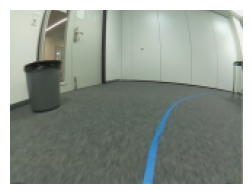

In [80]:
# alle Bildpfade laden
image_paths = get_image_files(image_directory_path)
print(f"Es wurden {len(image_paths)} Bilder gefunden")

# der erste Pfad auswählen und ausgeben (wenn du einen anderen willst, ändere den Index)
some_image_path = image_paths[42]
print(some_image_path)

# Bild laden und anzeigen
img = PILImage.create(some_image_path)
img.show()

# Dazugehörige Daten für Lenkung und Geschwindigkeit ausgeben
throttle, steering = read_data_from_json(some_image_path)
print(f"Geschwindigkeit {throttle:.2f} / Lenkung: {steering:.2f}")


### Daten betrachten

Wir können uns nun die Daten betrachten auf welche wir Trainieren wollen. In diesem Schritt können wir schädliche Daten erkennen und entfernen

*Wichtig*: Wenn du hier unlogische Daten, dann entferne diese Abschnitte aus den Trainingsdaten. Beispiel hierfür sind:
- Minus-Geschwindikeit (unser Modell soll nie Rückwärds fahren)
- Längere Abschnitt mit Null-Geschwindikeit (unser Fahrmodell soll nie anhalten)


In [81]:
%%time
# Wir können uns auch mal alle Fahrdaten als Diagramm betrachten, sowie Kennzahlen ermitteln.

# Das auslesen der Daten kann eine Weile dauern...
from multiprocessing.pool import ThreadPool
with ThreadPool(1000) as pool:
  vehicle_data = np.array(pool.map(read_data_from_json, image_paths))
all_throttles = vehicle_data[:,0]
all_steerings = vehicle_data[:,1]

print(f"Kennzahlen zu Lenkung: min={all_steerings.min():.2f}, max: {all_steerings.max():.2f}, Durchschnitt: {all_steerings.mean():.2f}")
print(f"Kennzahlen zu Geschwindigkeit: min={all_throttles.min():.2f}, max: {all_throttles.max():.2f}, Durchschnitt: {all_throttles.mean():.2f}")

Kennzahlen zu Lenkung: min=-0.80, max: 0.78, Durchschnitt: -0.03
Kennzahlen zu Geschwindigkeit: min=0.00, max: 0.20, Durchschnitt: 0.16
CPU times: user 5.15 s, sys: 1.42 s, total: 6.57 s
Wall time: 14.6 s


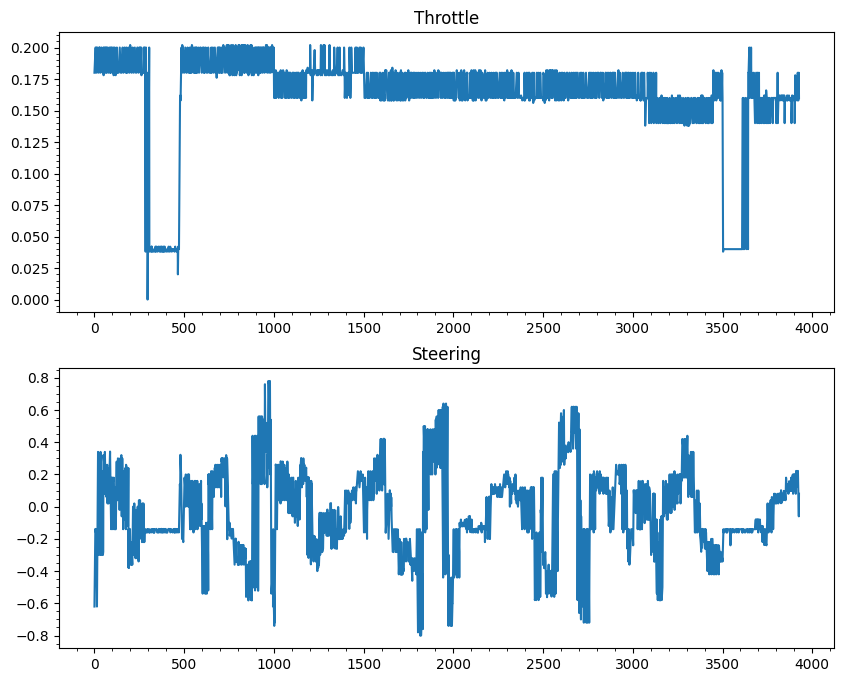

In [82]:
# Diagramm zeichnen
import matplotlib.style as mplstyle
mplstyle.use('fast')
fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 8))
ax1.plot(all_throttles)
ax1.set_title("Throttle")
ax1.minorticks_on()
ax2.plot(all_steerings)
ax2.set_title("Steering")
ax2.minorticks_on()

- Beim Throttle sehen wir noch ein paar Stellen, wo es Minus- oder Null-Werte hat, diese sollten wir für ein optimales Resultat entfernen
- Es hat aber teilweise noch ein paar 0-er drin, die sollten wir entfernen!
- Beim Steering sieht alles gut aus, wir sehen, dass Links- und Rechtskurven gefahren wurden

Wir werden zu Demozwecken aber in diesem Notebook so weitermachen

### Blau-Filter erstellen

Wir werden hier unseren Blau-Filter definieren, den wir im `DataLoaders` verwenden

In [83]:
# Filter-Funktion: Passe die Werte hier an, welche du im anderen Notebook ermittelt hast
def filter_image(pil_image):

    # Bild als array laden und Wertebereich sicherstellen (nötig für override_driving.py)
    image_array = np.array(pil_image)
    if not image_array.dtype == np.uint8:
      image_array *= 255

    # Color Filter
    lower1 = np.array([0, 75, 115]) # <- Werte können angepasst werden
    upper1 = np.array([115, 205, 255]) # <- Werte können angepasst werden
    color_filtered = cv2.inRange(image_array, lower1, upper1)

    # Kleinere Pixelbereiche entfernen
    kernel = np.ones((2, 2), np.uint8) # <- Werte können angepasst werden, z.B. (4,4)
    dilated_mask = cv2.erode(color_filtered, kernel, iterations=1)

    # Oberer Bildbereich abschneiden
    dilated_mask[:70, :] = 0.0 # <- Wert kann angepasst werden, z.B. [:50, :]

    # Zurück zu (Black/White) Bild konvertieren
    pil_image_bw = PILImage(Image.fromarray(dilated_mask))
    return pil_image_bw


  # Transfomer Klasse für den Dataloader
class BlueFilter(DisplayedTransform):
    def __call__(self,
        item,
        split_idx:int=None, # Index of the train/valid dataset
    ):
        img, target = item
        img = filter_image(img)
        return img, target


### DataLoaders erstellen

Wir erstellen diese in diesem Beispiel aus einem `DataBlock`. Als Input haben wir einen `ImageBlock` und für die Fahrdaten einen `RegressionBlock`

In [84]:
data_block = DataBlock(
    blocks=(ImageBlock(), RegressionBlock(n_out=2)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=read_data_from_json,
    item_tfms=[BlueFilter()]  # <- Unser Blaufilter
)

dls = data_block.dataloaders(
    Path(image_directory_path),
    bs=64,shuffle=True,
    # num_workers=2,
    # persistent_workers=True,
    )

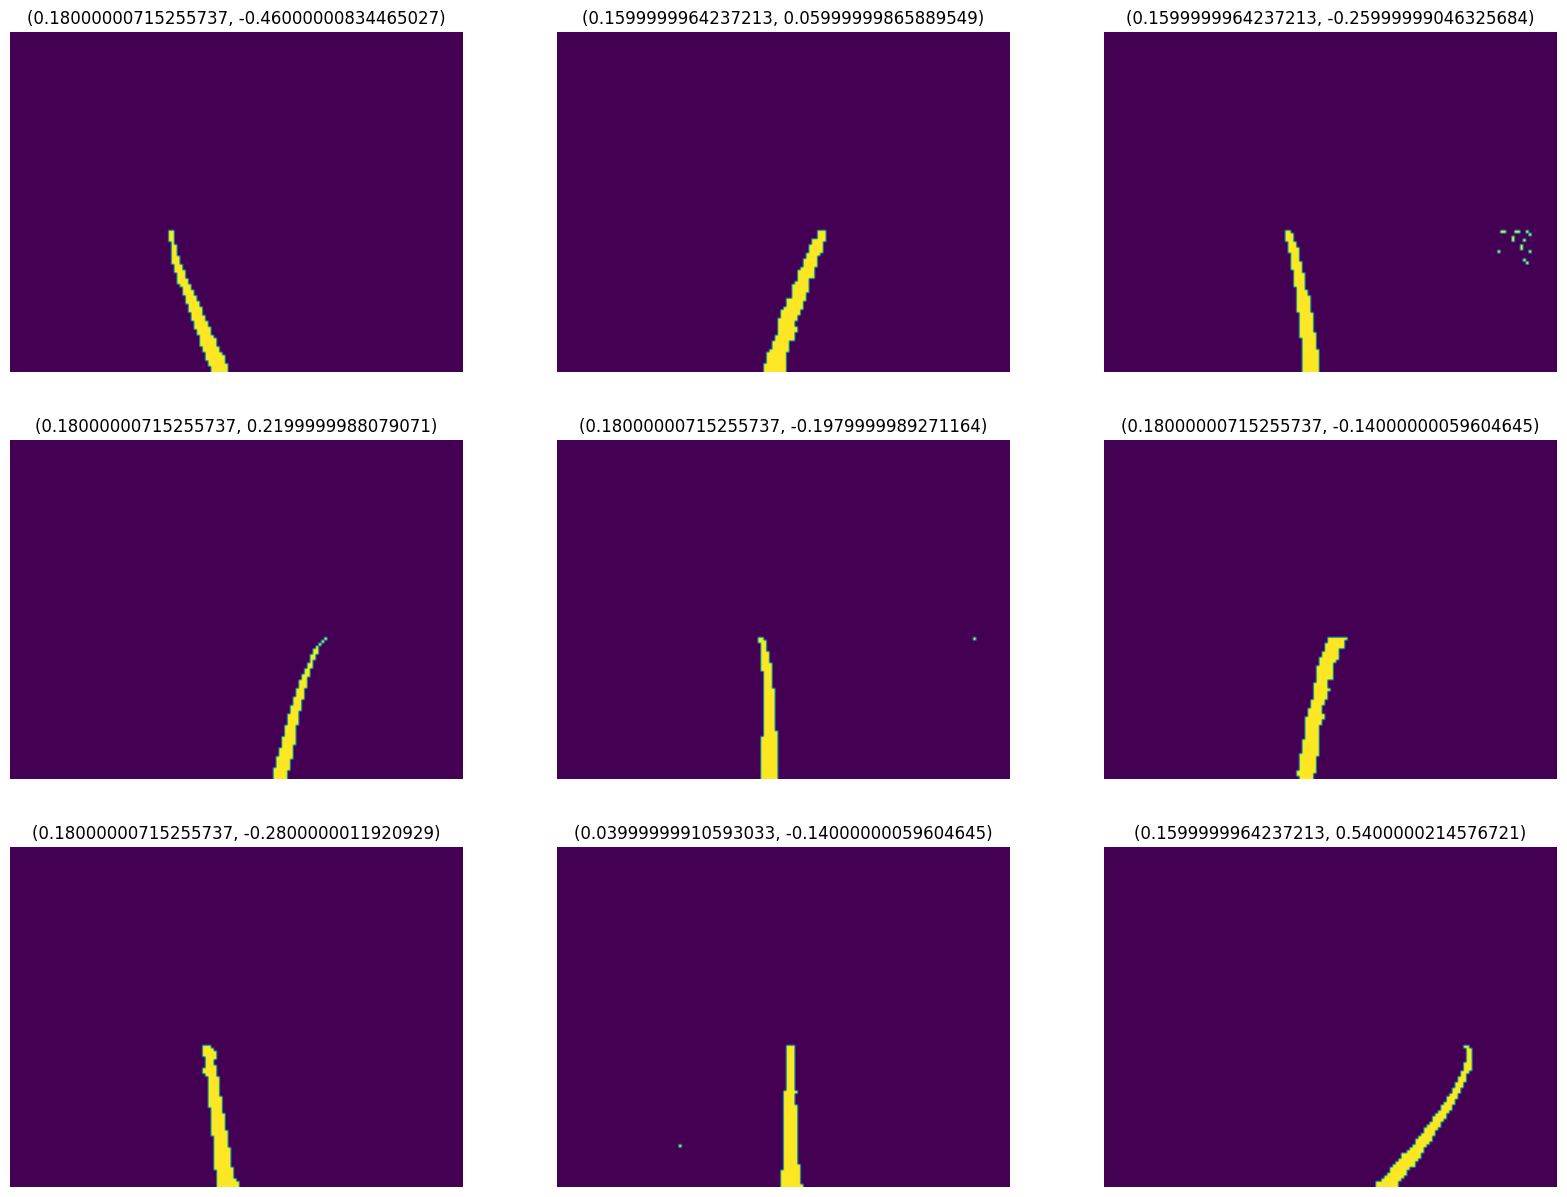

In [85]:
# Auch hier können wir uns ein Batch anzeigen lassen. Oben werden die Fahrdaten angezeigt (throttle, stearing)

dls.show_batch(figsize=(20,15))

# Betrachte die Fahrdaten an. Stimmen sie mit den Bildern überein?

## Model definieren & trainieren

### Model definieren

Wir werden auch hier ein eigenes Modell trainieren. Dieses besteht aus mehrere Convolution-Layer mit Optimierungen wie BatchNormalization und Dropout's und Aktivierungsfunktionen (für Details schaue im Theorie-Teil der Woche 02/03 nach). Ganz am Schluss leiten wir aus den letzten Neuronen einmal die beiden Outputs für `throttle` und `steering` ab.

In [86]:
# Model definieren
class ModelBlueFilter(nn.Module):
    def __init__(self):
        super(ModelBlueFilter, self).__init__()
        
        self.debug = True
        self.dropout_proba = 0.1

        self.conv1 = nn.Conv2d(1, 24, kernel_size=(5, 5), stride=(2, 2))
        self.conv2 = nn.Conv2d(24, 32, kernel_size=(5, 5), stride=(2, 2))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))

        self.max_pooling_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.max_pooling_2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.batch1 = nn.BatchNorm2d(24)
        self.batch2 = nn.BatchNorm2d(32)
        self.batch3 = nn.BatchNorm2d(64)

        self.line_batch1 = nn.BatchNorm1d(128)
        self.line_batch2 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(self.dropout_proba)
        self.relu = nn.ReLU()

        # nachgeschaltetes klassisches Netzwerk initialisieren
        self.flatten = nn.Flatten(1, -1)

        self.linear1 = nn.Linear(192, 128)

        self.linear2 = nn.Linear(128, 64)

        self.throttle1 = nn.Linear(64, 32)
        self.steering1 = nn.Linear(64, 32)

        self.throttle2 = nn.Linear(32, 1)
        self.steering2 = nn.Linear(32, 1)

    def forward(self, x):
        # convolution layer 1
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = self.max_pooling_1(x)
        x = self.dropout(x)

        # convolution layer 2
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)
        x = self.max_pooling_2(x)
        x = self.dropout(x)

        # convolution layer 3
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.flatten(x)

        x = self.linear1(x)
        x = self.line_batch1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.line_batch2(x)
        x = self.relu(x)
        x = self.dropout(x)

        throttle = self.throttle1(x)
        throttle = self.relu(throttle)
        throttle = self.dropout(throttle)

        throttle = self.throttle2(throttle)

        angle = self.steering1(x)
        angle = self.relu(angle)
        angle = self.dropout(angle)
        angle = self.steering2(angle)

        return torch.cat((throttle, angle), 1)


In [87]:
# Model erstellen
model = ModelBlueFilter()

# Model auf GPU senden
model.to(device)

# Alles zu einem Learner zusammenfassen
learn = Learner(
    dls=dls, # Unser Dataloaders
    model=model, # Unser Modell
    loss_func=MSELossFlat(), # Als Loss-Funktion wählen wir den MSELoss, welcher für Regression geeignet ist
    # cbs=ProgressCallback()
    )

In [88]:
# Und schauen uns das Modell an
learn.summary()

Model (Input shape: 64 x 1 x 120 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 24 x 58 x 78   
Conv2d                                    624        True      
____________________________________________________________________________
                     64 x 32 x 27 x 37   
Conv2d                                    19232      True      
____________________________________________________________________________
                     64 x 64 x 12 x 17   
Conv2d                                    51264      True      
____________________________________________________________________________
                     64 x 64 x 10 x 15   
Conv2d                                    36928      True      
____________________________________________________________________________
                     64 x 64 x 8 x 13    
Conv2d                                    36928      True      
BatchNorm2d                               48         True 

### Model trainieren

In [89]:
suggested_lr = learn.lr_find().valley
print(f"Die empfohlene Lernrate ist {suggested_lr}")

Die empfohlene Lernrate ist 0.00174


In [90]:
%%time

# Model trainieren (dauert eine wie viel, je nach dem wie viele Daten es sind)
learn.fit_one_cycle(10, suggested_lr)

epoch,train_loss,valid_loss,time
0,0.071253,0.010857,00:25
1,0.033054,0.005263,00:20
2,0.019690,0.004216,00:23
3,0.014078,0.003632,00:20
4,0.011791,0.003558,00:22


CPU times: user 16.2 s, sys: 1.9 s, total: 18.1 s
Wall time: 1min 53s


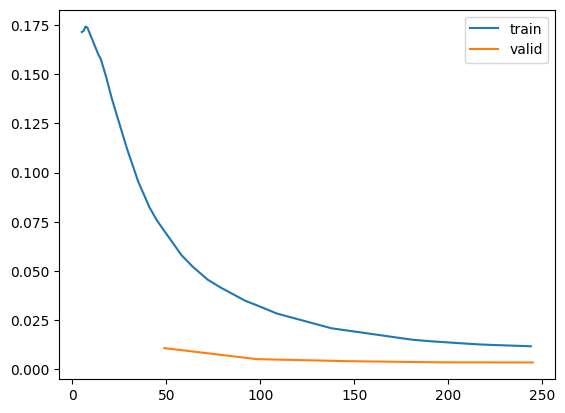

In [91]:
# Wir können uns die Lernkurve anschauen und sehen, wie sich das Modell mit den Validierungsdaten verhält
learn.recorder.plot_loss()

## Validierung

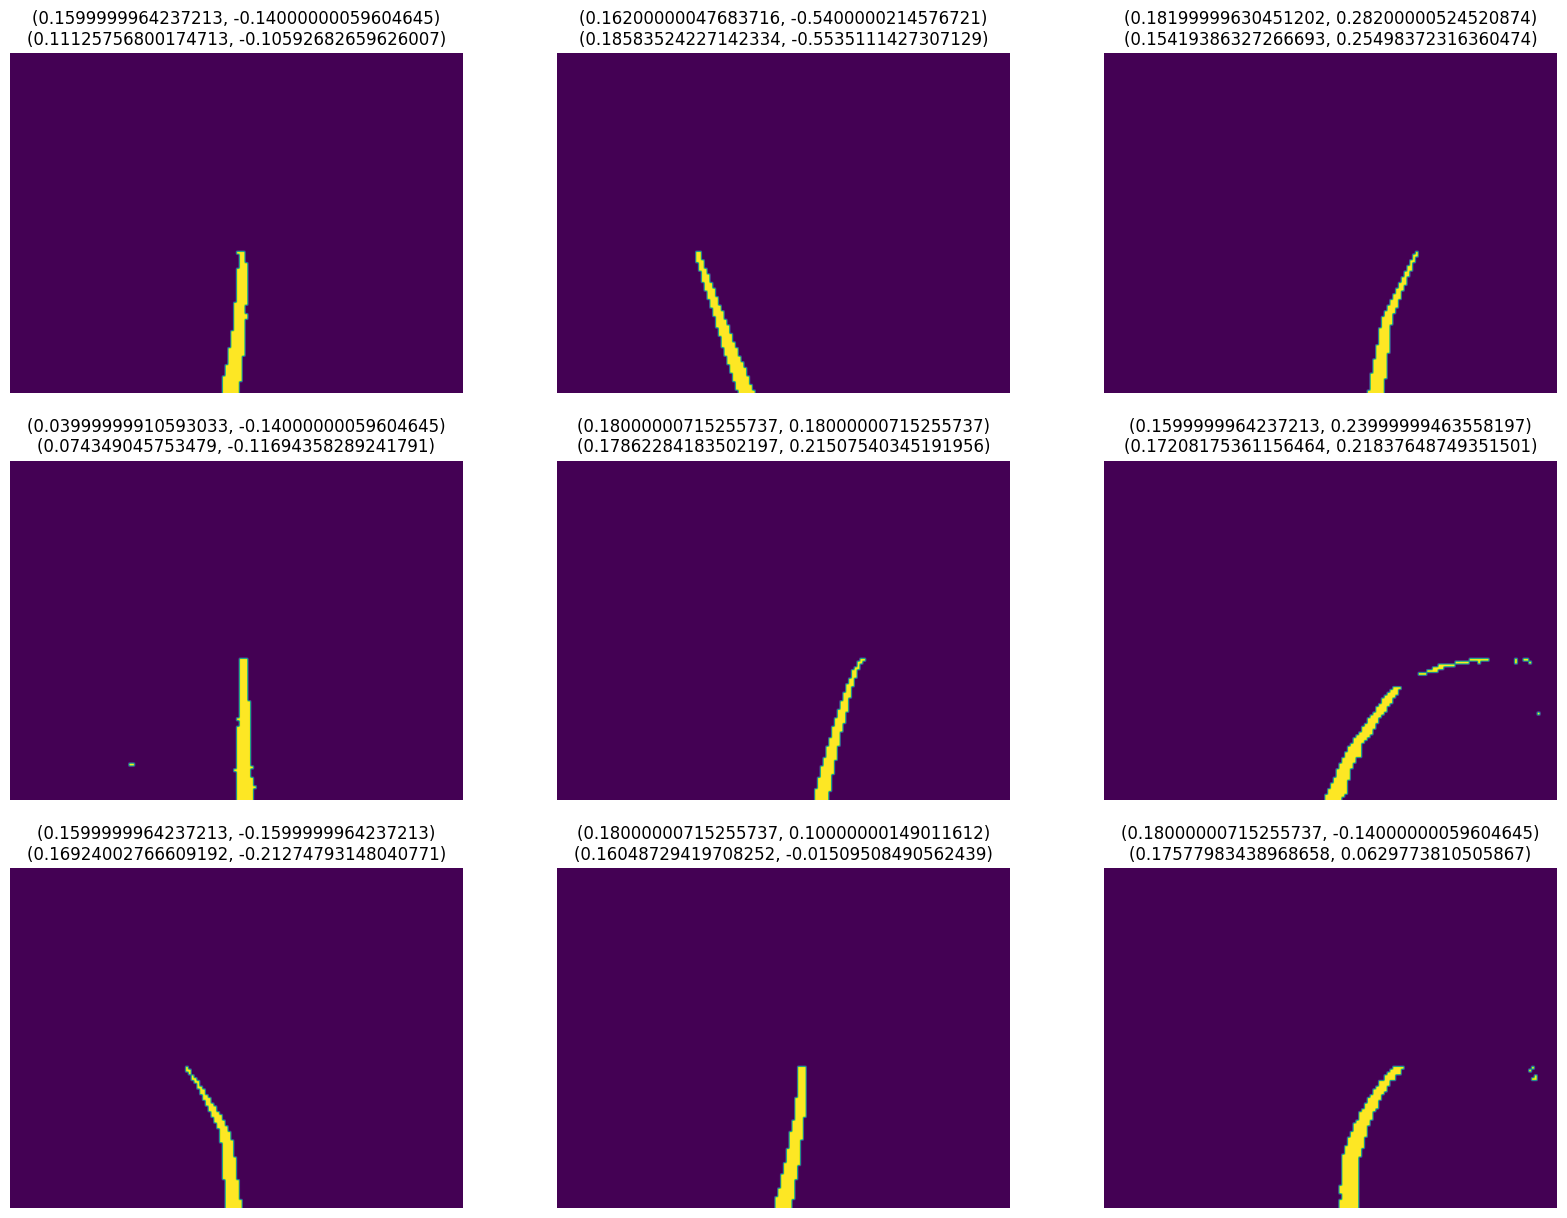

In [92]:
# Wir schauen uns einige Vorhersagen an.
# Legende:
#   - Oben: Soll Throttle, Speed
#   - Unten Vorhersage Throttle, Speed
learn.show_results(ds_idx=1, figsize=(20,15))

# Sehen die Ausgaben für Geschw. und Steuerung sinnvoll aus?
# (passen sie zum Bild, also z.B. Steuerung hat bei einer Linkskurve einen Minuswert, bei einer Rechtkurve ein Pluswert)?

In [93]:
# Wir lassen uns das Validierungs-Set vorhersagen und extrahieren die Werte
res = learn.get_preds()
val_throttles = res[0][:,0]
val_steerings = res[0][:,1]

pred_throttles = res[1][:,0]
pred_steerings = res[1][:,1]

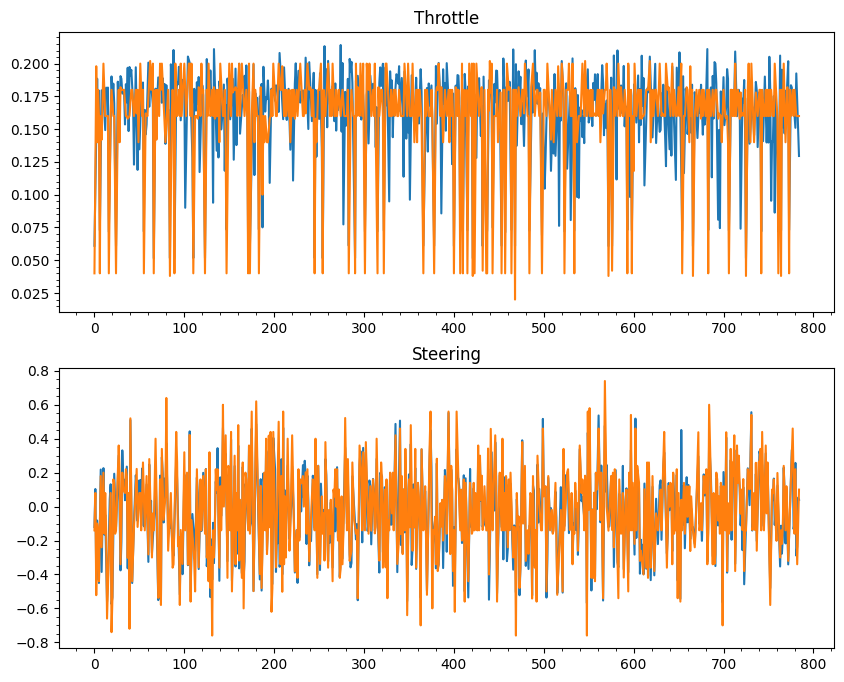

In [94]:
# Nun können wir uns diese anzeigen lassen
fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 8))
ax1.plot(val_throttles)
ax1.plot(pred_throttles)
ax1.set_title("Throttle")
ax1.minorticks_on()
ax2.plot(val_steerings)
ax2.plot(pred_steerings)
ax2.set_title("Steering")
ax2.minorticks_on()

# Macht das Modell in etwas, was wir wollen? Wo sehen wir noch verbesserungen?

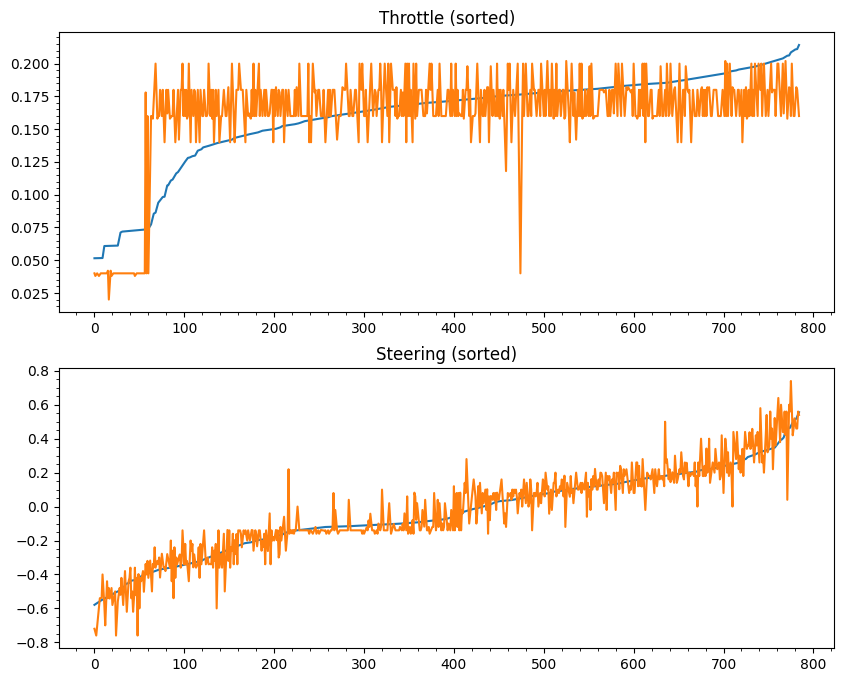

In [95]:
# Eventuell macht es auch Sinn, die Werte aufsteigend zu sortieren, damit man die Abweichungen besser sieht
val_steerings, pred_steerings = map(torch.tensor, zip(*sorted(zip(val_steerings, pred_steerings), key=lambda x: x[0])))
val_throttles, pred_throttles = map(torch.tensor, zip(*sorted(zip(val_throttles, pred_throttles), key=lambda x: x[0])))

# Nun können wir uns diese anzeigen lassen
fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 8))
ax1.plot(val_throttles)
ax1.plot(pred_throttles)
ax1.set_title("Throttle (sorted)")
ax1.minorticks_on()
ax2.plot(val_steerings)
ax2.plot(pred_steerings)
ax2.set_title("Steering (sorted)")
ax2.minorticks_on()

In [96]:
# Und noch eine Metrik. Für Regression bietet sich R2 Score an
# Der R2 Score zeigt in Prozent wie "gut" die Regression ist (0.0=Sehr schlecht / 1.0=Perfekt)
# Wenn du mehr darüber wissen willst, schaue hier nach: https://studyflix.de/statistik/bestimmtheitsmas-2146
r2_score = R2Score()
r2_both = r2_score(res[0], res[1])
r2_throttle = r2_score(val_throttles, pred_throttles)
r2_steering = r2_score(val_steerings, pred_steerings)
print(f"R2 Score for both: {r2_both:.2f}")
print(f"R2 Score for throttle: {r2_throttle:.2f}")
print(f"R2 Score for steering: {r2_steering:.2f}")


R2 Score for both: 0.92
R2 Score for throttle: 0.48
R2 Score for steering: 0.91


## Modell verwenden (ONNX Export)

In [97]:
# onnx installieren
!pip install onnx --quiet

In [100]:
from PIL import Image
import torch
from torchvision import transforms
import onnx

## Wir definieren, wo wir das ONNX speichern wollen
onnx_export_filename = Path('/content/drive/MyDrive/AI-Challenge/models/self_driving_model_blaufilter.onnx')

## ONNX überschreibt die Datei, falls sie schon existiert. Daher prüfen wir hier ob das der Fall ist um nicht versehentlich etwas zu überschreiben
if onnx_export_filename.exists():
  raise Exception(f"onnx Modell {onnx_export_filename} existiert schon - lösche es zuerst oder bennene es um wenn du es behalten willst")

# Wir holen uns das Model aus dem Learner
model = learn.model

# Und versetzten es in den "Eval" Modus, damit ist es bereit für Vorhersagen
model.eval()

# Wir brauchen ein Beispiel-Bild um die Input-Shape für ONNX festzulegen.
with Image.open(some_image_path) as img:
    convert_tensor = transforms.ToTensor()
    # Bild filter
    img = filter_image(img)
    input_tensor_example = convert_tensor(img).unsqueeze(0)
    # Hier können wir uns anschauen, wie die Shape aussieht. So weiss ONNX was es erwarten kann.
    print(img.shape, input_tensor_example.shape)


# Prüfen, ob wir mit GPU lernen oder ohne, da der Input davon abhängig ist
if default_device().type == 'cuda':
  input_tensor_example = input_tensor_example.cuda()

# Model speichern
torch.onnx.export(
    model,
    input_tensor_example,
    onnx_export_filename,
    input_names=["image"],
    output_names=["data"]
)

print(f"Model wurde als ONNX exportiert nach: {onnx_export_filename}")

(120, 160) torch.Size([1, 1, 120, 160])
Model wurde als ONNX exportiert nach: /content/drive/MyDrive/AI-Challenge/models/self_driving_model_blaufilter.onnx


Nun können wir unser Modell auf das Auto laden und laufen lassen. Schafft es schon der blauen Linie nachzufahren?